In [140]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LassoCV
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns


In [141]:
entire_df = pd.read_csv('data.csv') # Load the file
entire_df.head() # check the first few rows, to see if it has laoded correctly

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Split the data

In [142]:
train, test = train_test_split(entire_df, train_size=0.7, random_state=42)
train, validation = train_test_split(train, train_size=0.7, random_state=42)

In [143]:
print(train.shape, validation.shape, test.shape) # check if it is correct

(3341, 96) (1432, 96) (2046, 96)


## DEV TEAM

In [144]:
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0:1]
y_train = y_train.values.ravel() # flattens the df to 1-dim array


x_val = validation.iloc[:, 1:]
y_val = validation.iloc[:, 0:1]
y_val = validation.values.ravel() # flattens the df to 1-dim array
y_val = validation.iloc[:, 0].values.ravel()

df_x = x_val
df_y = y_val

## VALIDATION TEAM ONLY

### (ctrl + /) on the cells content to uncomment ;)

In [145]:
# train, test = train_test_split(entire_df, train_size=0.7, random_state=42)
# train, validation = train_test_split(train, train_size=0.7, random_state=42)

# x_train = train.iloc[:, 1:]
# y_train = train.iloc[:, 0].values.ravel()


# x_val = validation.iloc[:, 1:]
# y_val = validation.iloc[:, 0].values.ravel()

# df_x = x_val
# df_y = y_val

# x_test = test.iloc[:, 1:]
# y_test = test.iloc[:, 0].values.ravel()

# df_x = x_test
# df_y = y_test

## END OF VALIDATION TEAM ONLY

In [146]:
def filter_data(input_df, train_x_df): # Applies the same changes for multiple df
    threshold = 0.00 # Selecting the variance threshold - very low
    sel = VarianceThreshold(threshold=threshold)
    transformed_features = sel.fit_transform(train_x_df)
    selected_columns = sel.get_support(indices=True)
    selected_columns = input_df.columns[selected_columns]
    selected_df = input_df[selected_columns]
    selected_df # df with the low variance columns removed
    return selected_df

In [147]:
def replace_outliers_with_iqr(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Zastępowanie outlierów medianą kolumny
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), df[col].median(), df[col])
    
    return df

In [148]:
def normalize_data(input_df):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(input_df)
    normalized_df = pd.DataFrame(normalized_data, columns=input_df.columns)
    return normalized_df

In [149]:
def calculate_metrics(actual, predictions):
    """
    as actual use the real data, as predictions use the predicted values
    
    Helper func. to calculate multiple scores
    """
    ## Compute accuracy
    #accuracy = accuracy_score(actual, predictions)

    ## Compute precision
    #precision = precision_score(actual, predictions, zero_division='warn')

    ## Compute recall
    #recall = recall_score(actual, predictions)

    ## Compute F1-score
    ##f1 = f1_score(actual, predictions)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(fpr, tpr)

    ## Print all the metrics
    #print("Accuracy:", accuracy)
    #print("Precision:", precision)
    #print("Recall:", recall)
    #print("F1-score:", f1)
    print("ROC AUC score:", roc_auc)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Compute confusion matrix
    #cm = confusion_matrix(actual, predictions)

    ## Plot confusion matrix
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(cm, annot=True, fmt="d", cmap="YlGn", cbar=False)
    #plt.xlabel('Predicted')
    #plt.ylabel('Actual')
    #plt.title('Confusion Matrix')
    #plt.show()


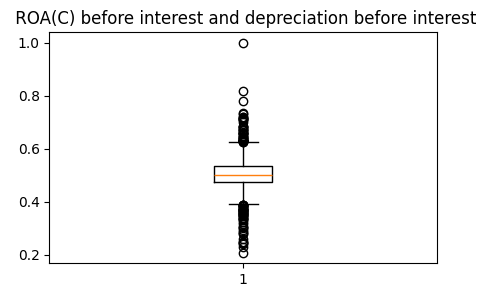

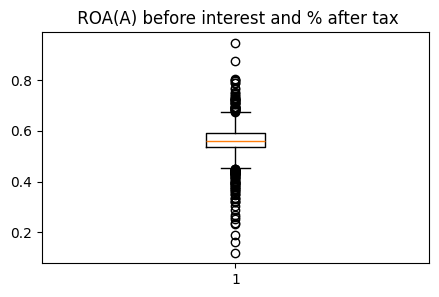

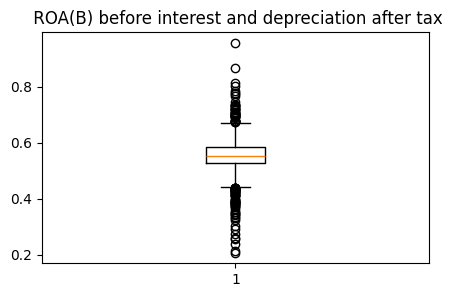

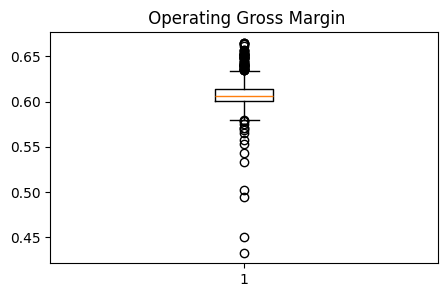

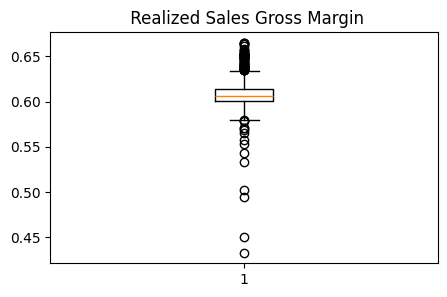

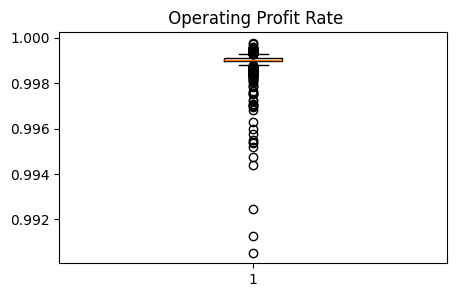

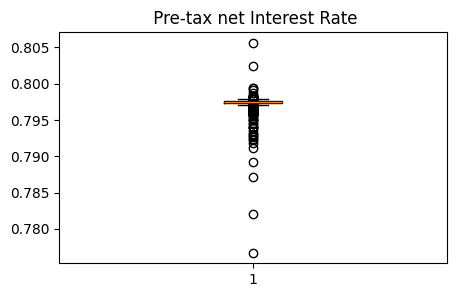

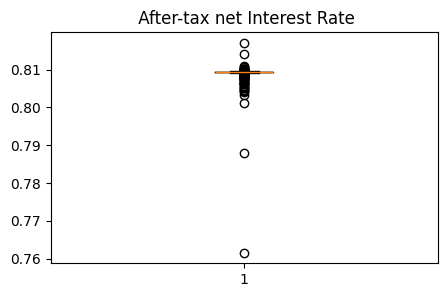

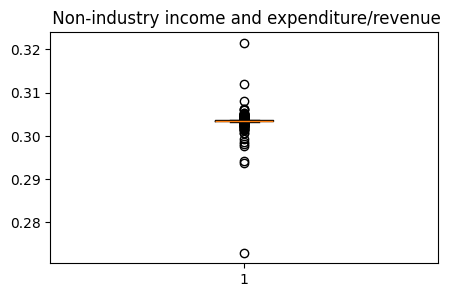

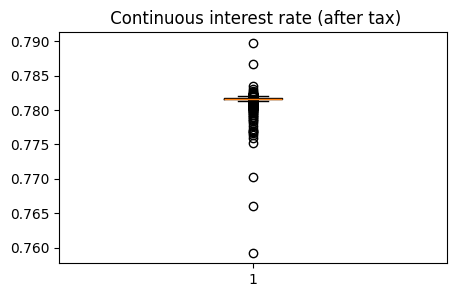

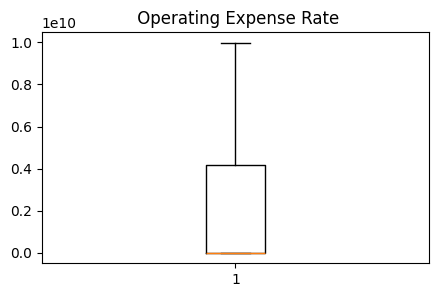

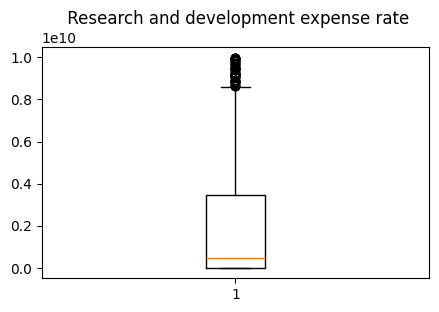

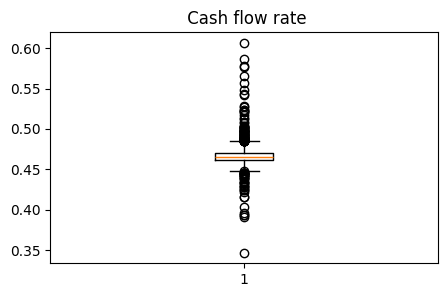

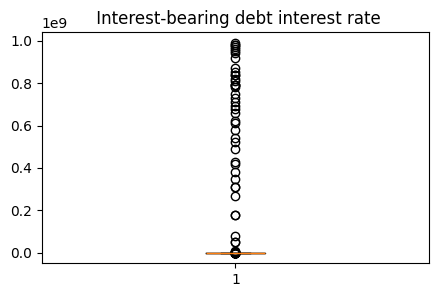

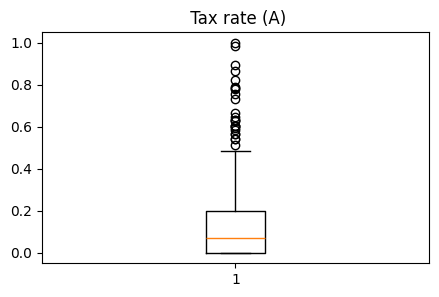

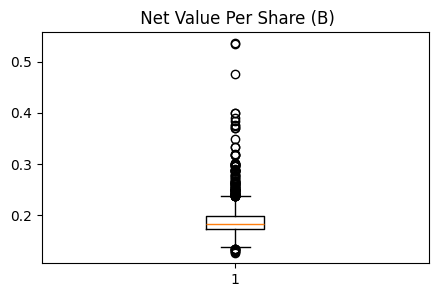

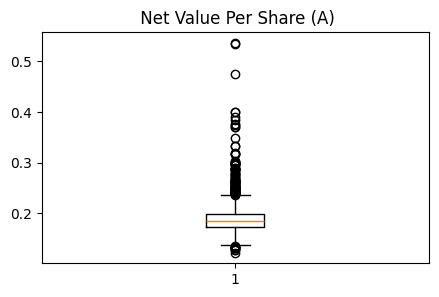

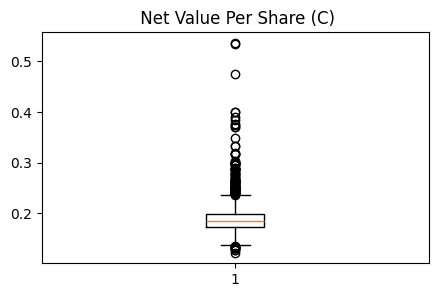

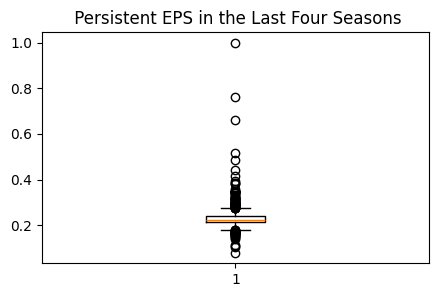

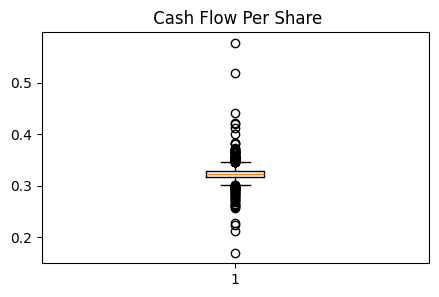

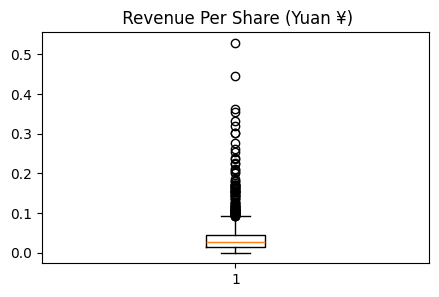

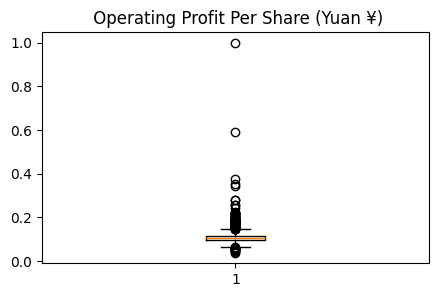

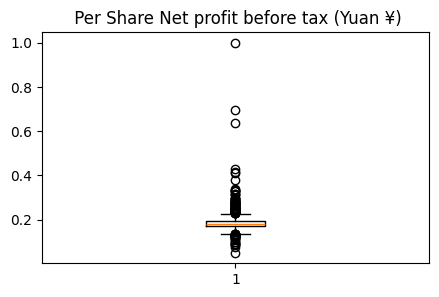

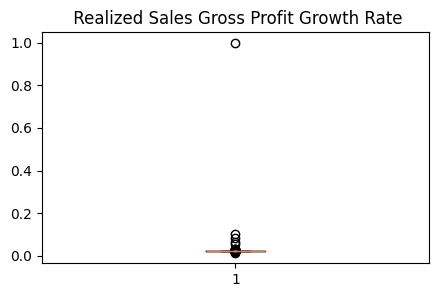

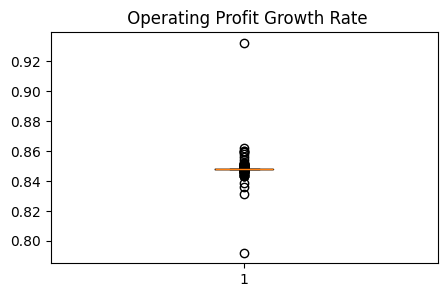

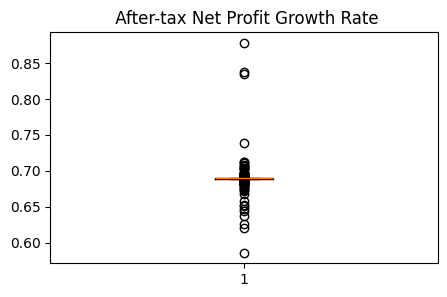

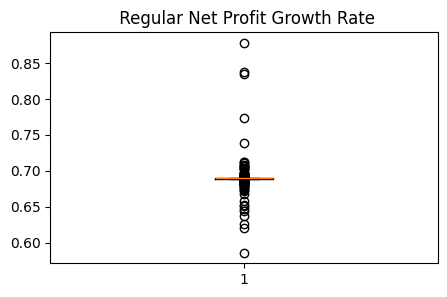

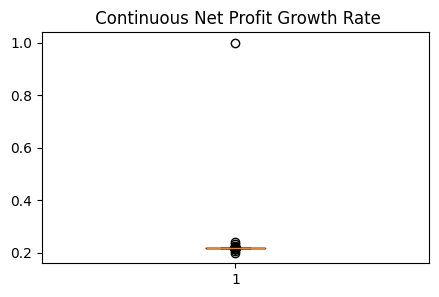

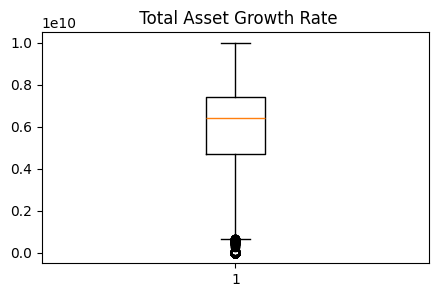

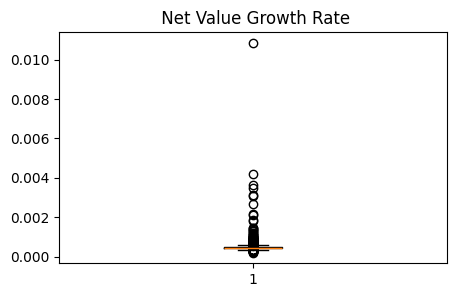

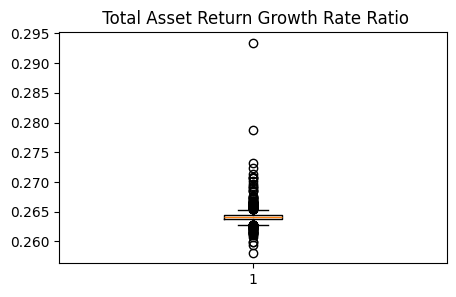

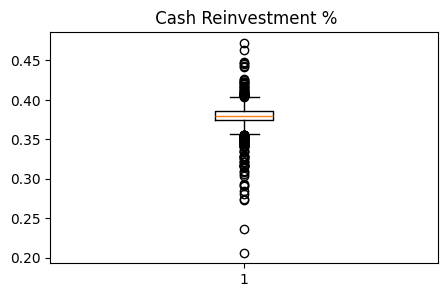

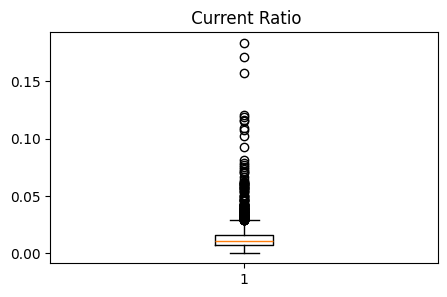

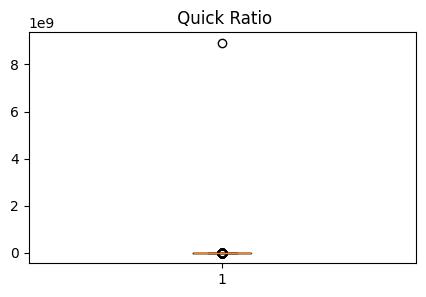

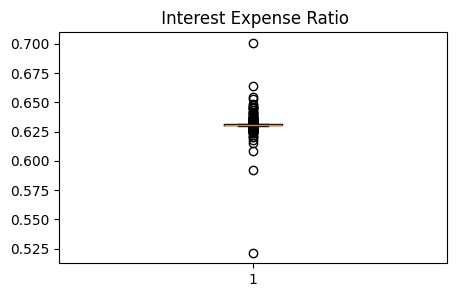

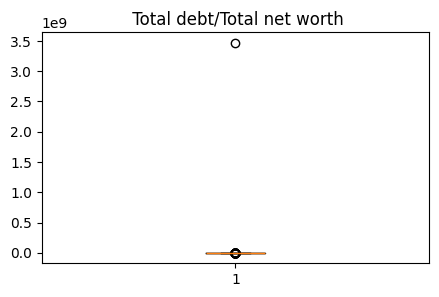

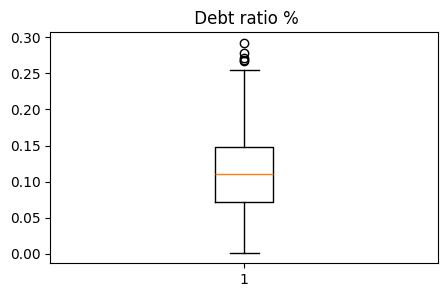

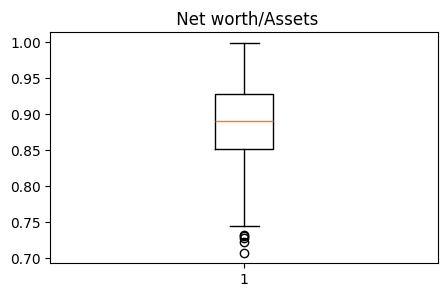

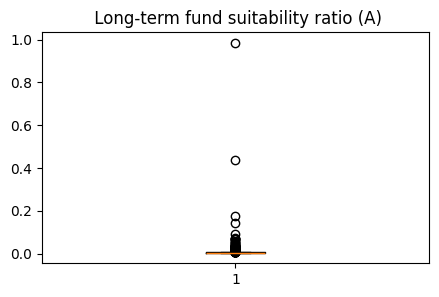

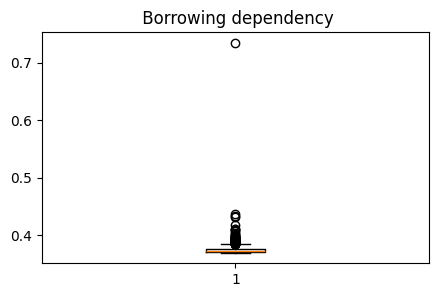

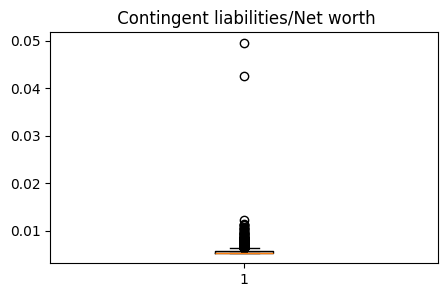

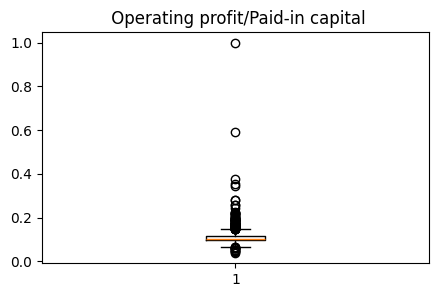

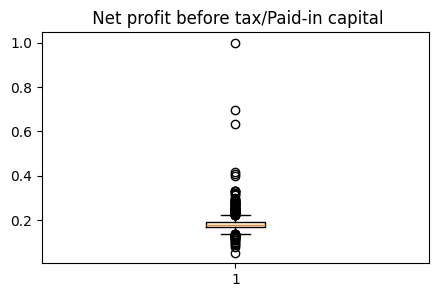

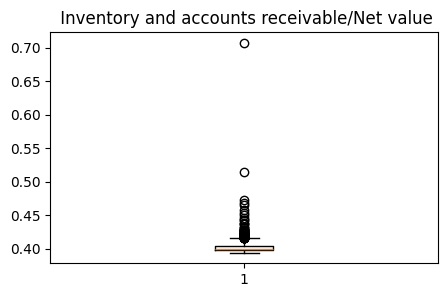

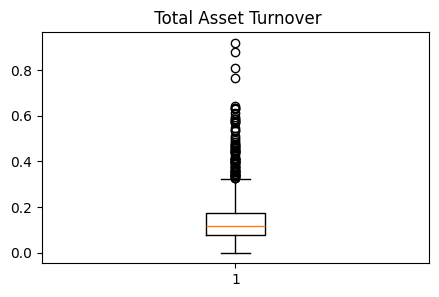

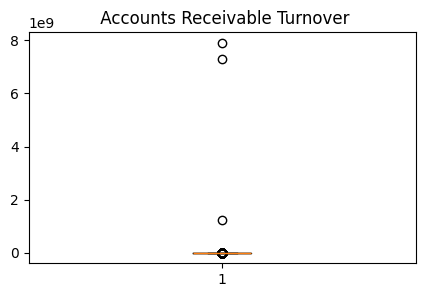

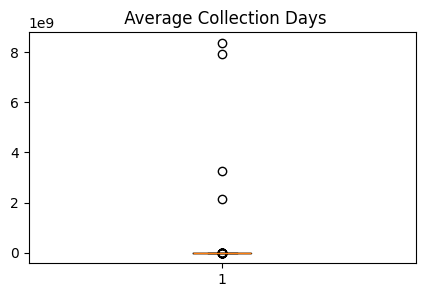

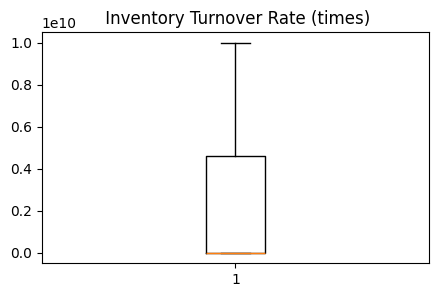

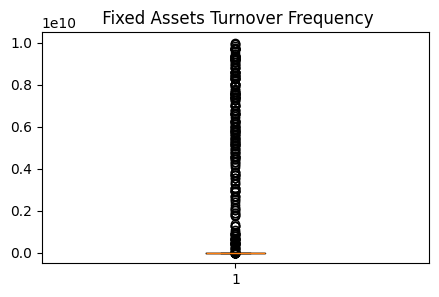

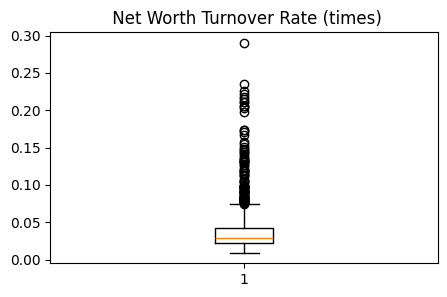

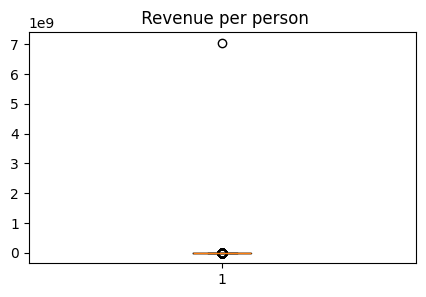

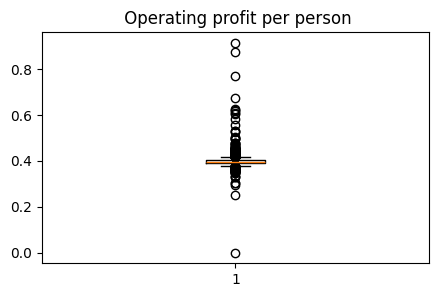

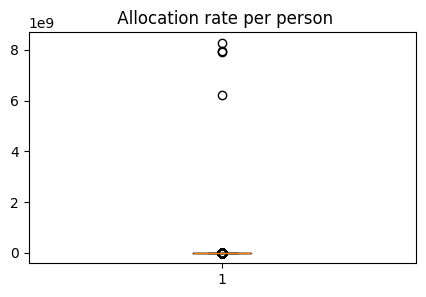

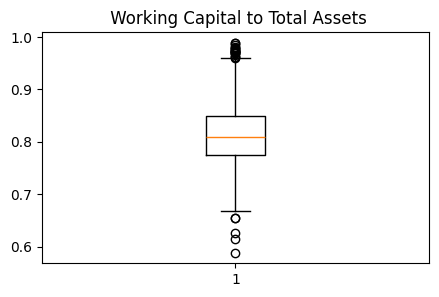

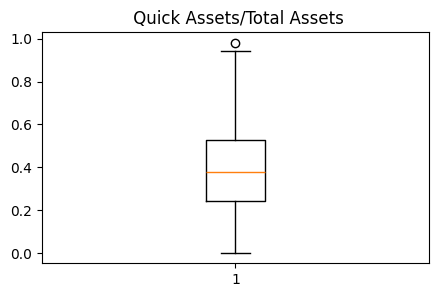

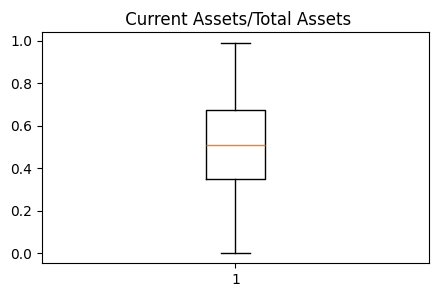

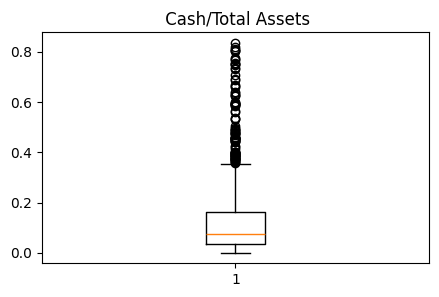

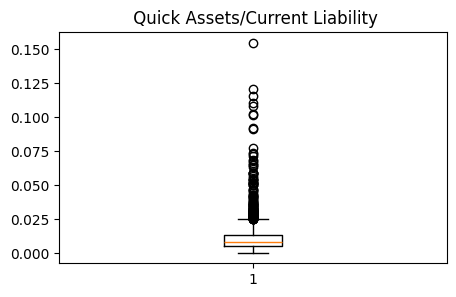

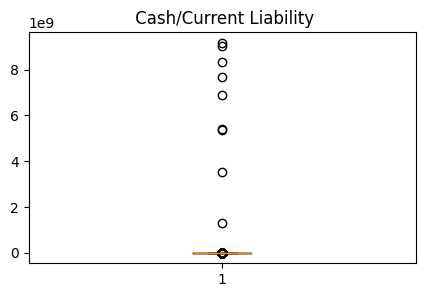

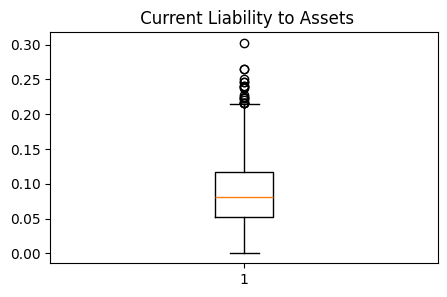

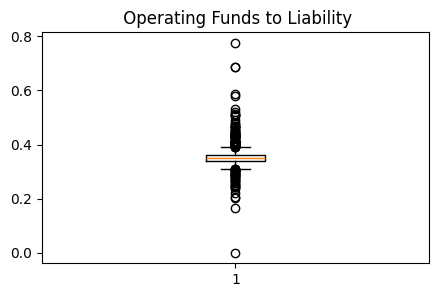

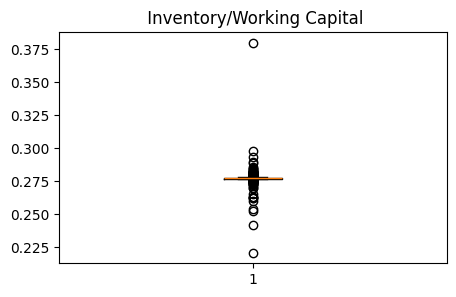

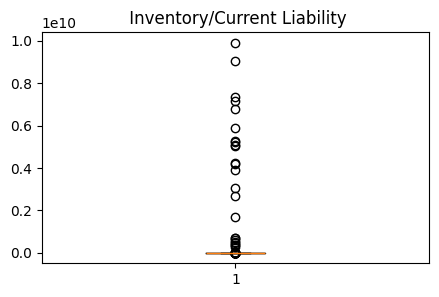

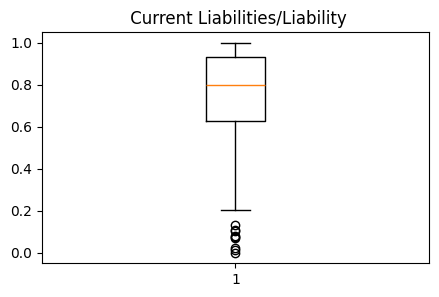

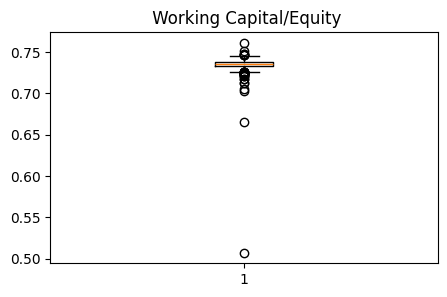

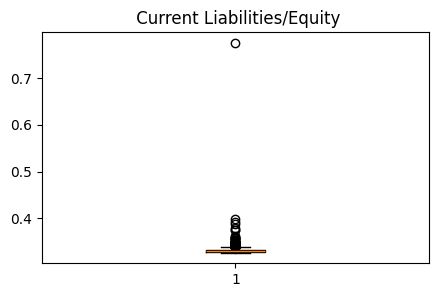

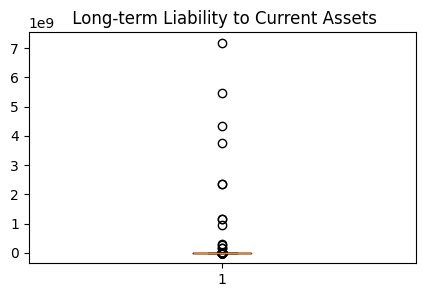

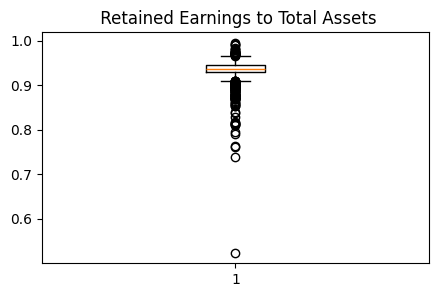

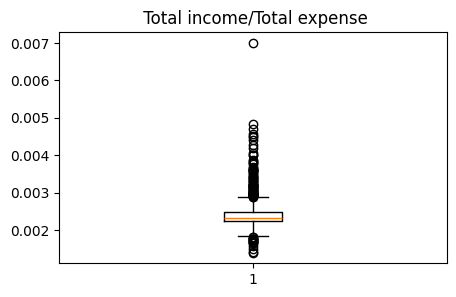

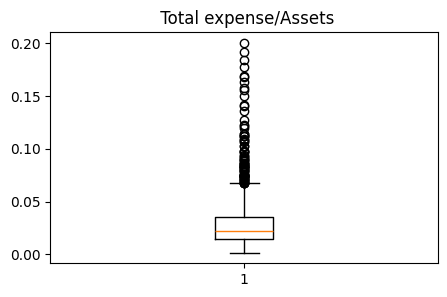

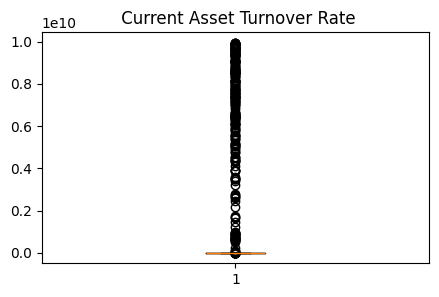

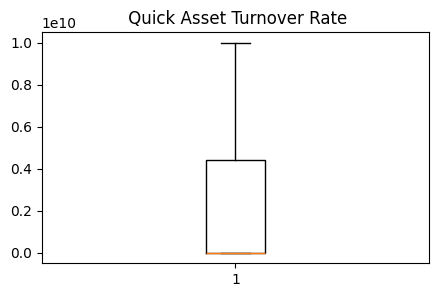

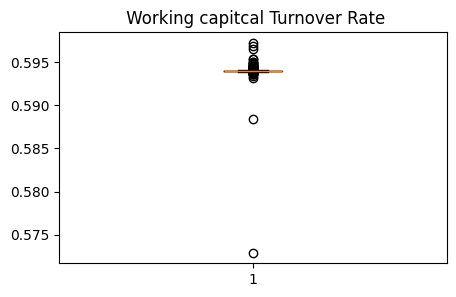

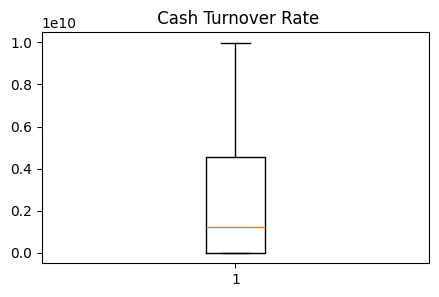

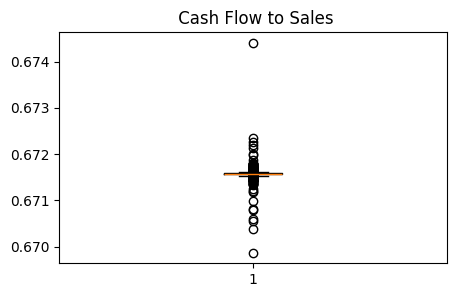

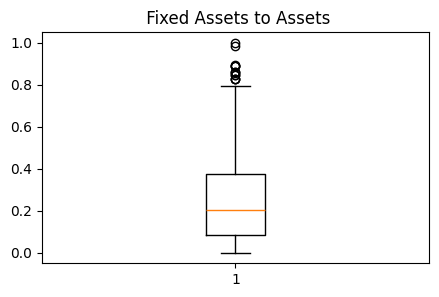

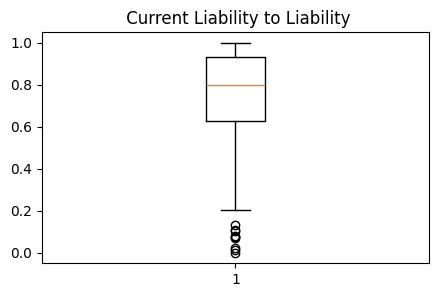

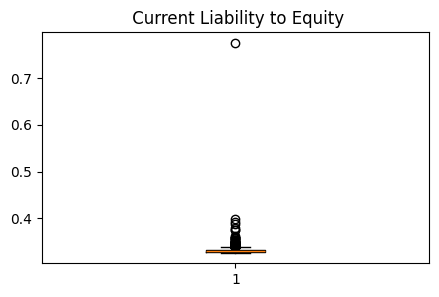

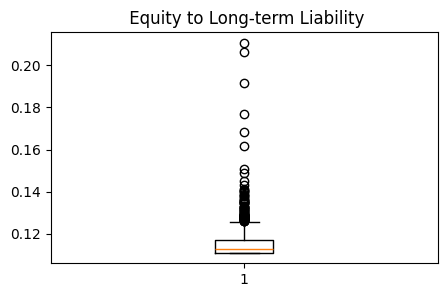

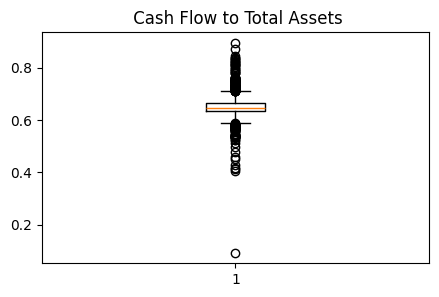

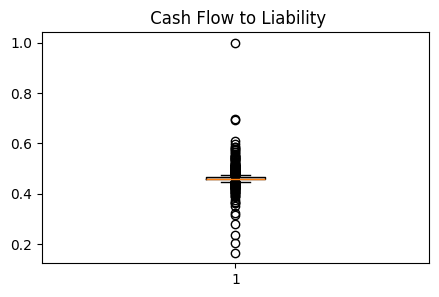

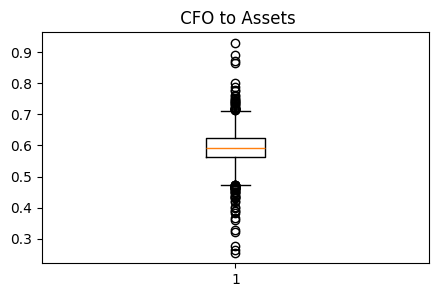

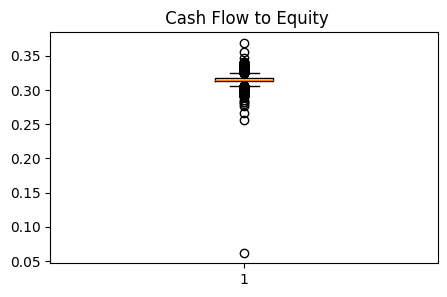

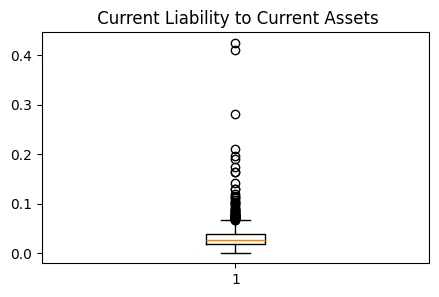

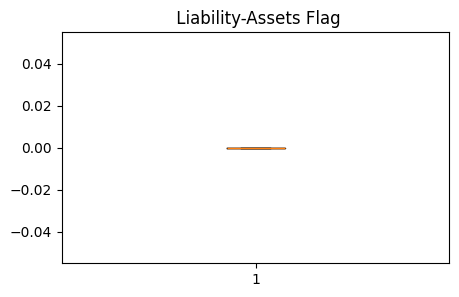

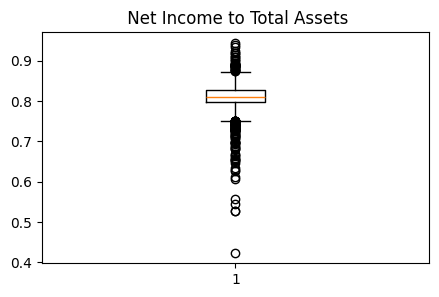

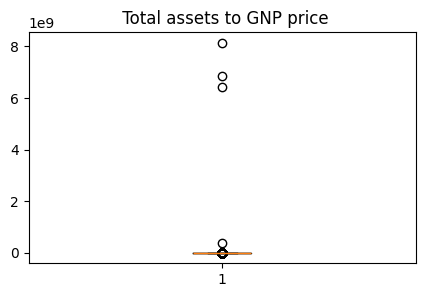

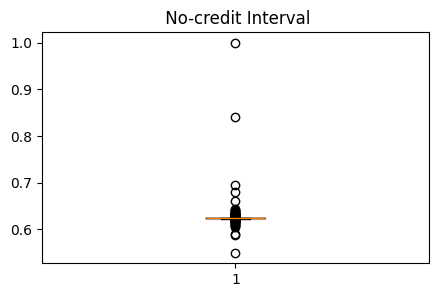

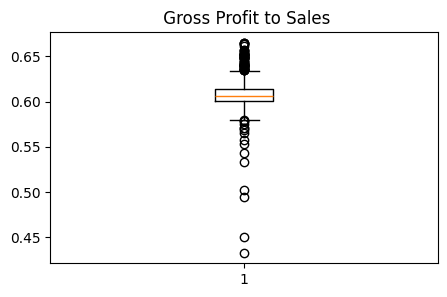

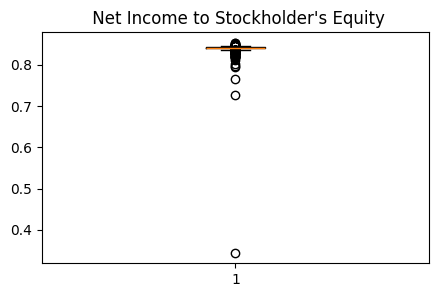

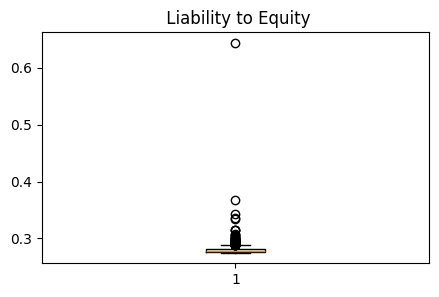

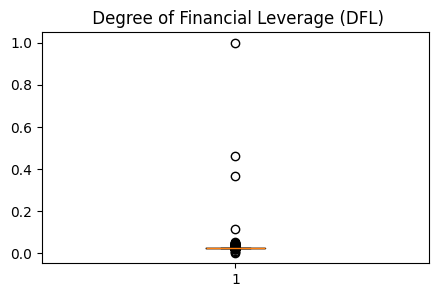

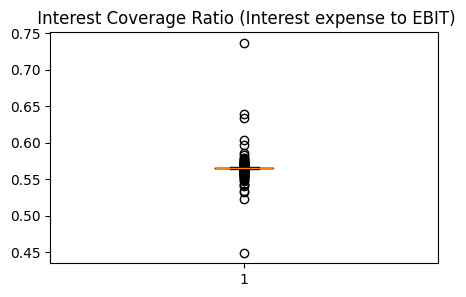

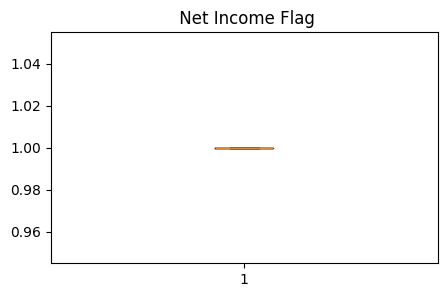

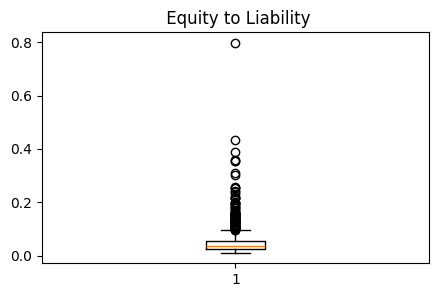

In [150]:
for column in df_x.columns:
    plt.figure(figsize=(5, 3))  # Rozmiar każdego wykresu
    plt.boxplot(df_x[column])  # Rysowanie wykresu pudełkowego dla konkretnej zmiennej
    plt.title(column)  # Tytuł wykresu
    plt.show()

In [151]:
df_x = filter_data(df_x, x_train)
x_train = filter_data(x_train, x_train)
df_x = replace_outliers_with_iqr(df_x)
x_train = replace_outliers_with_iqr(x_train)

C:\Users\sylge\AppData\Local\Temp\ipykernel_8736\178209353.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), df[col].median(), df[col])
C:\Users\sylge\AppData\Local\Temp\ipykernel_8736\178209353.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), df[col].median(), df[col])
C:\Users\sylge\AppData\Local\Temp\ipykernel_8736\178209353.py:10: SettingWithCopyWarning: 
A v

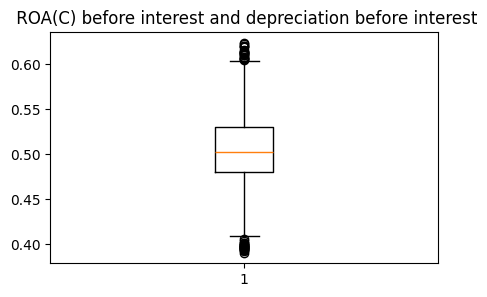

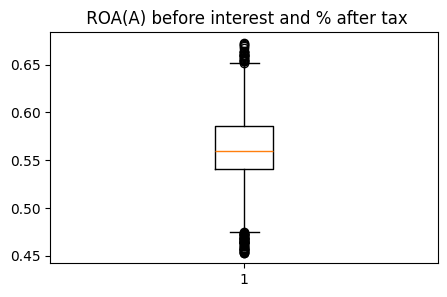

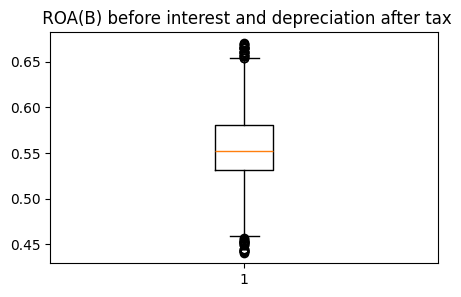

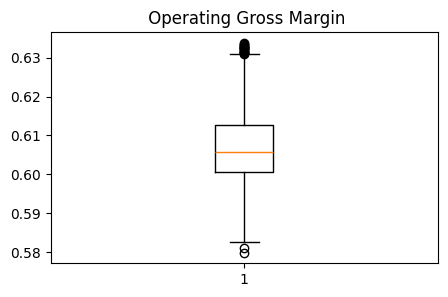

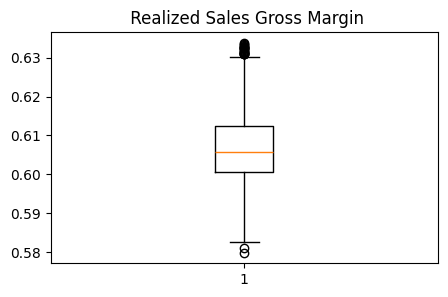

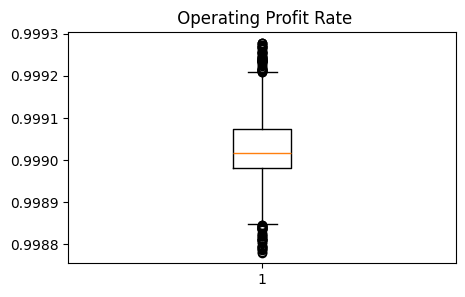

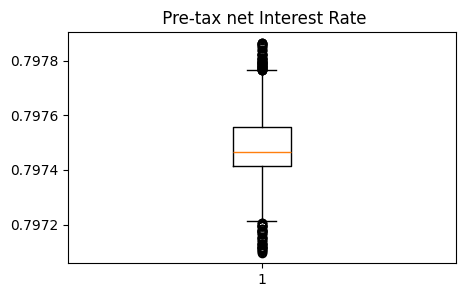

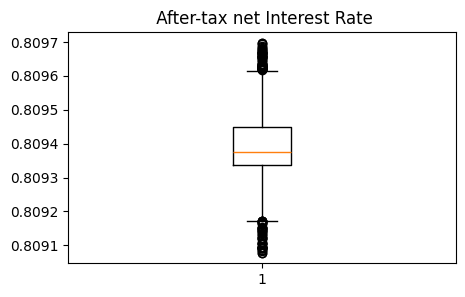

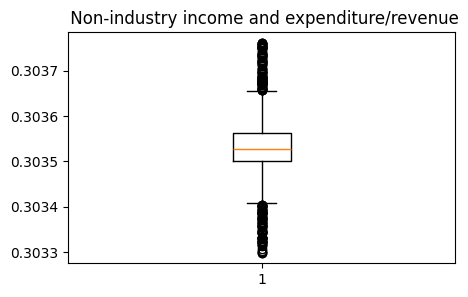

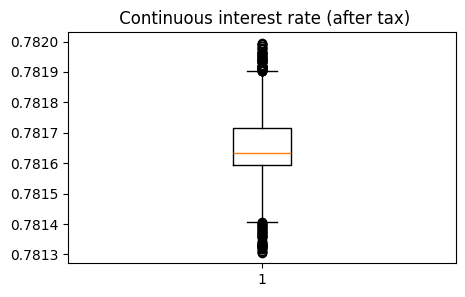

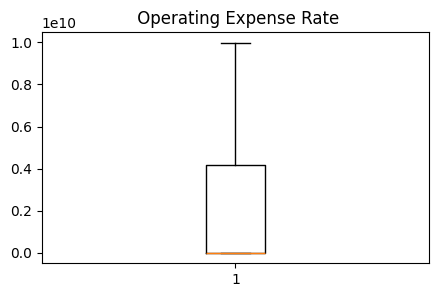

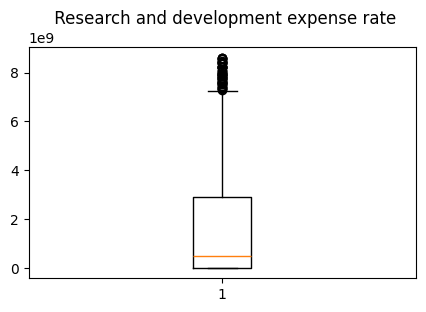

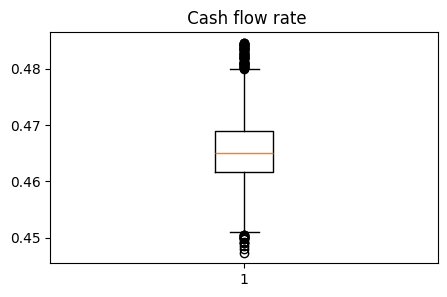

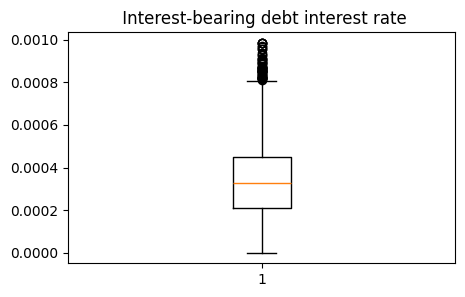

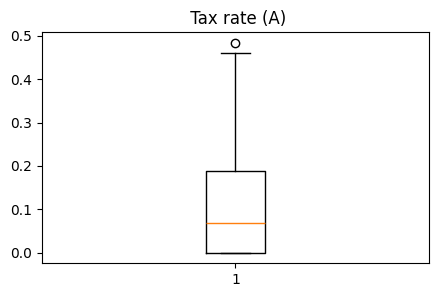

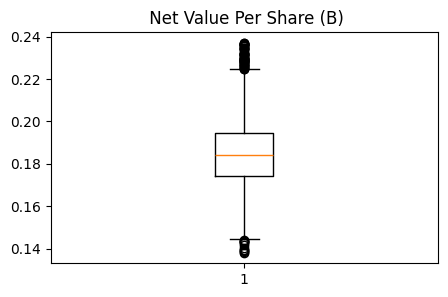

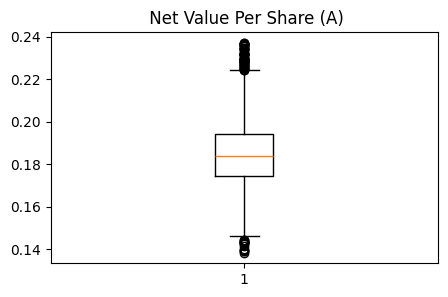

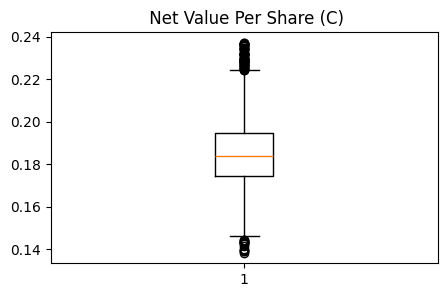

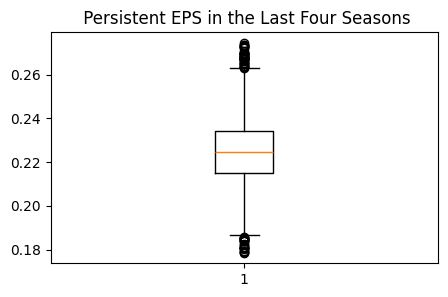

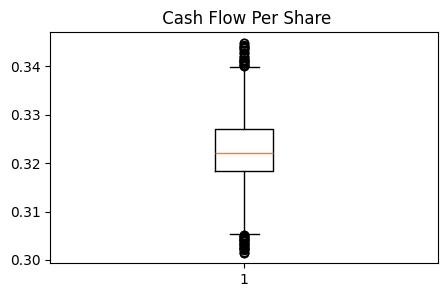

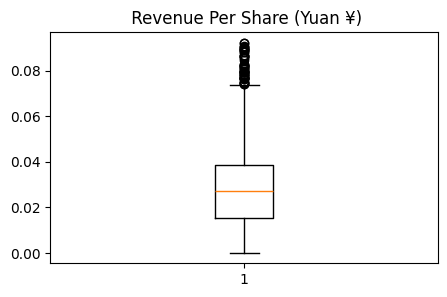

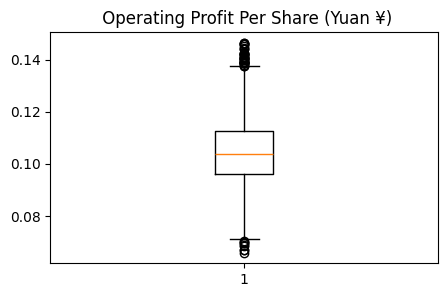

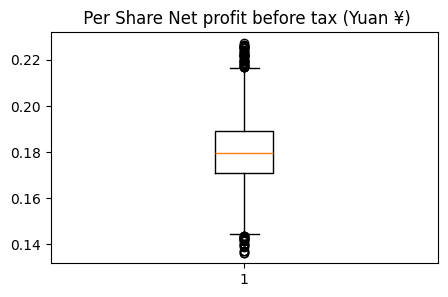

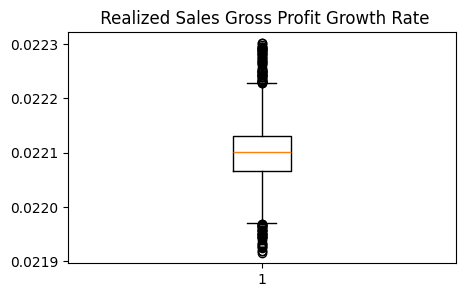

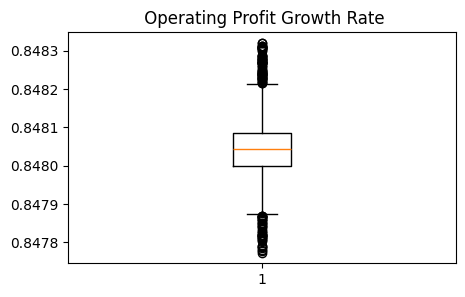

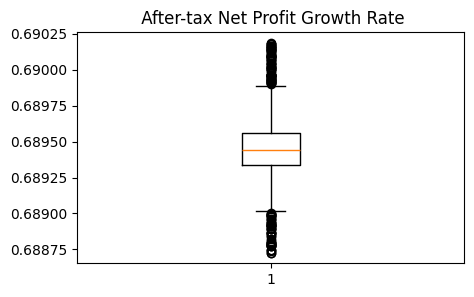

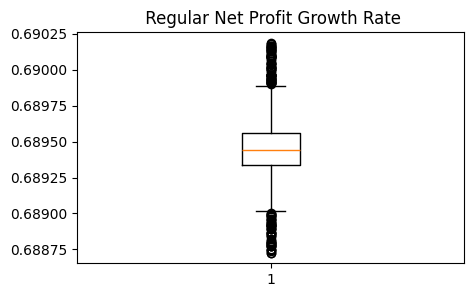

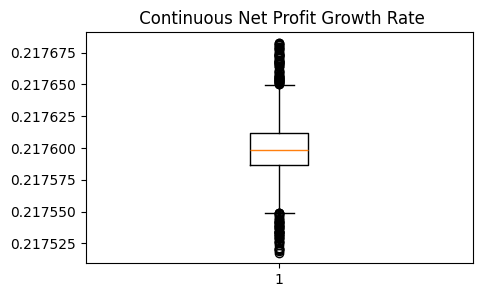

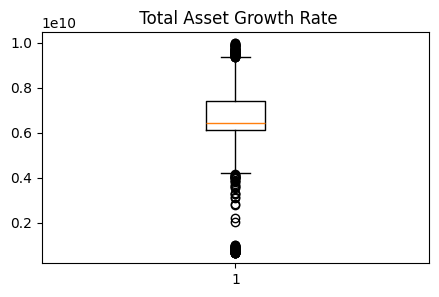

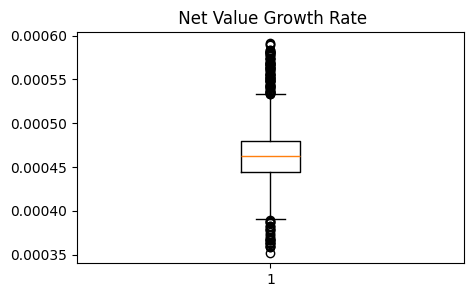

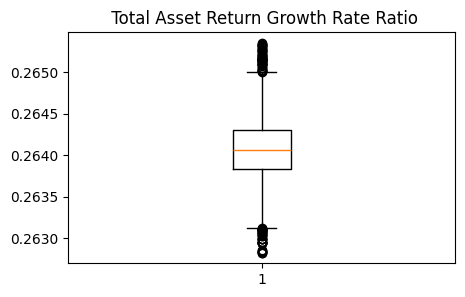

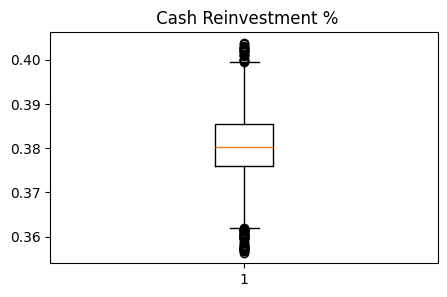

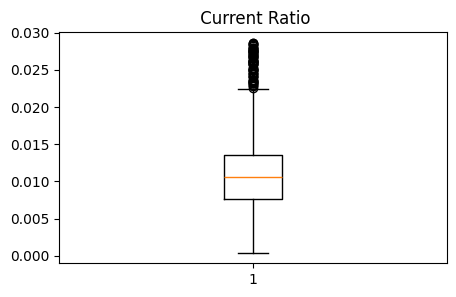

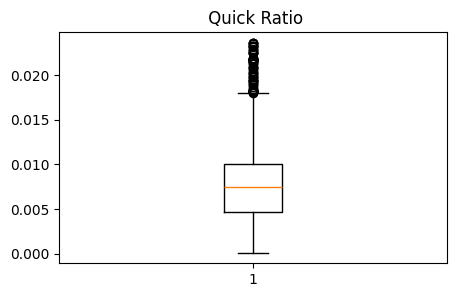

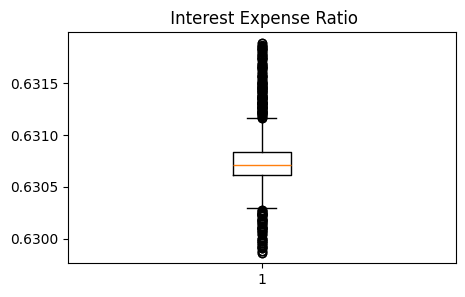

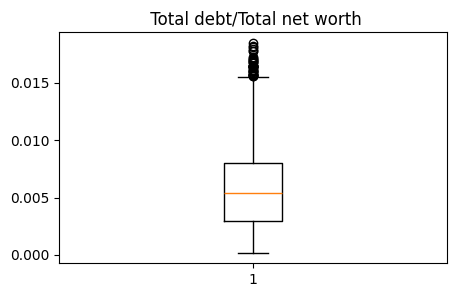

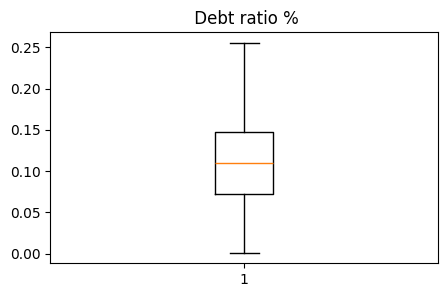

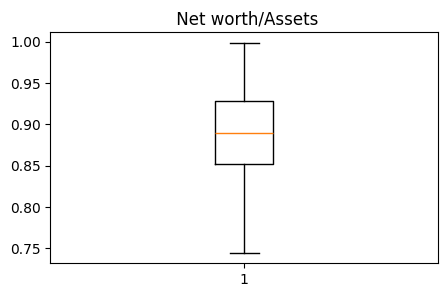

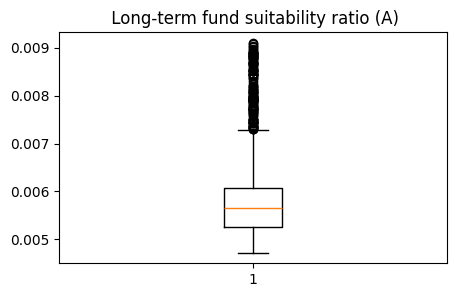

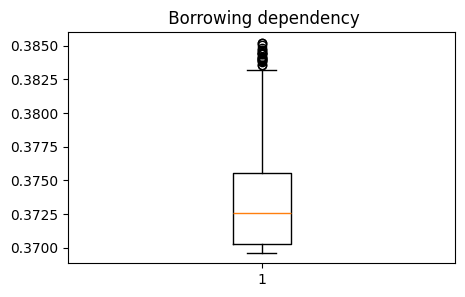

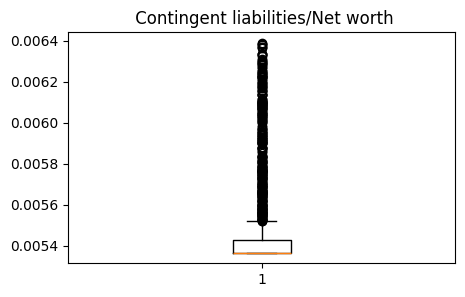

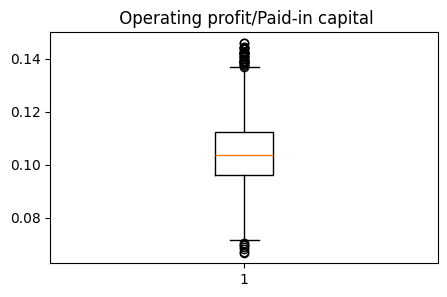

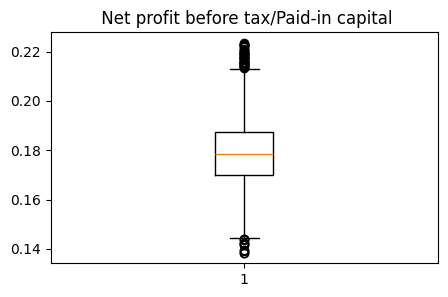

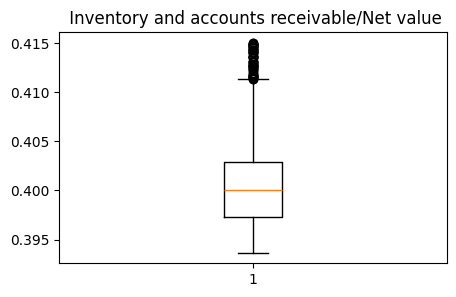

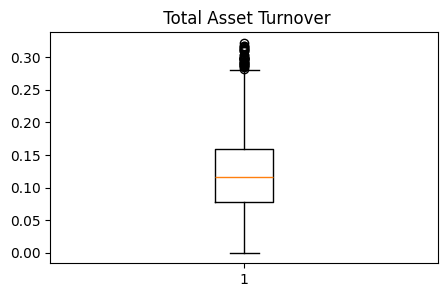

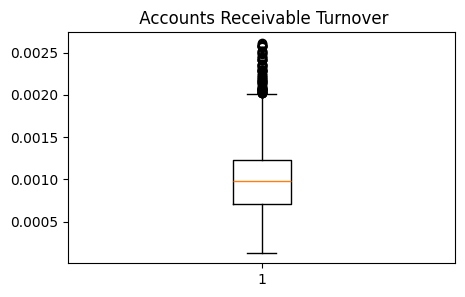

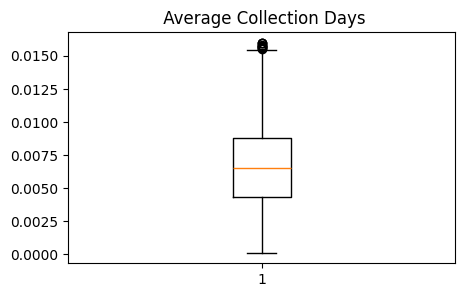

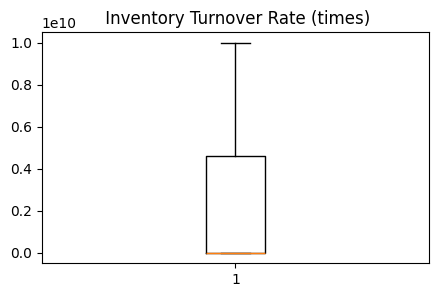

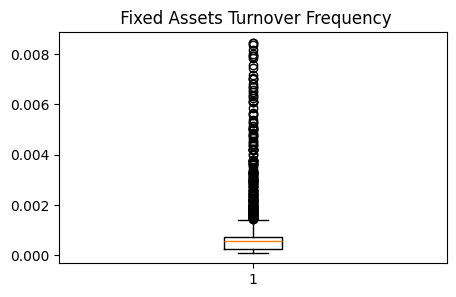

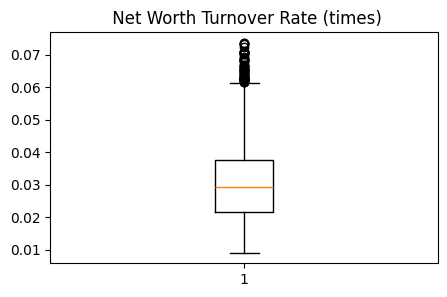

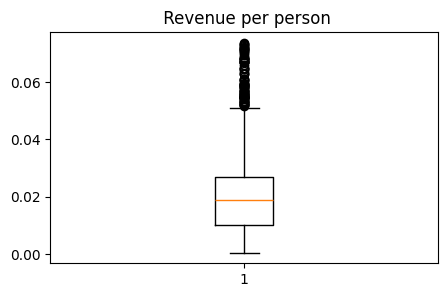

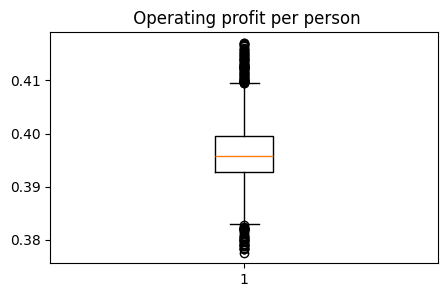

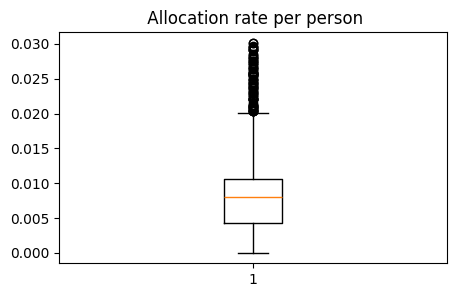

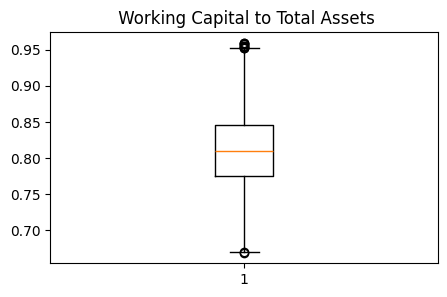

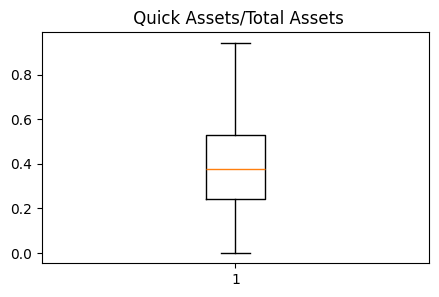

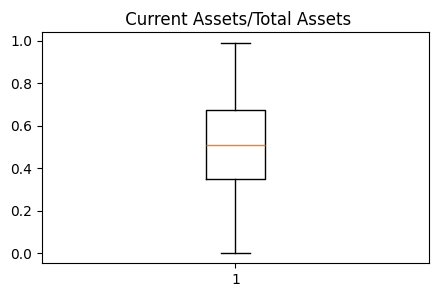

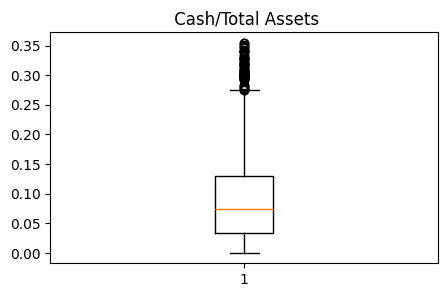

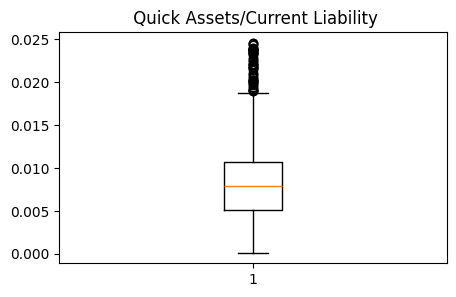

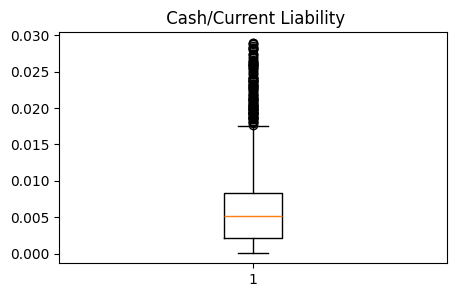

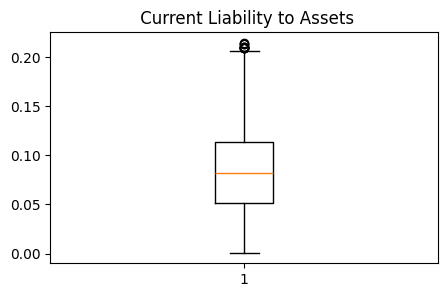

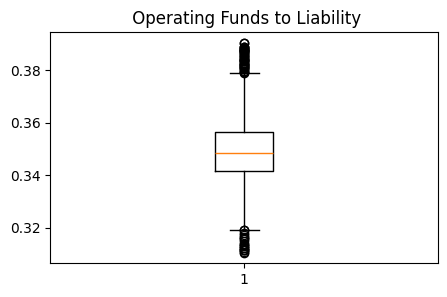

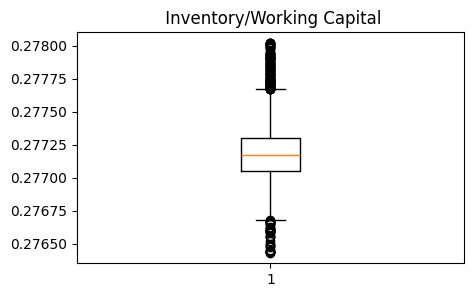

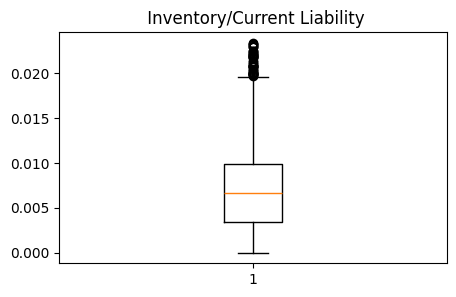

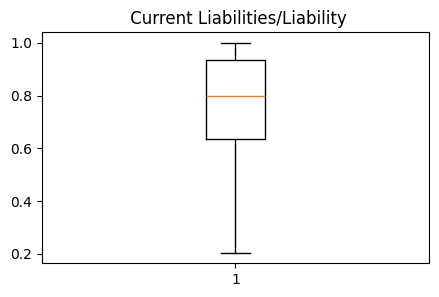

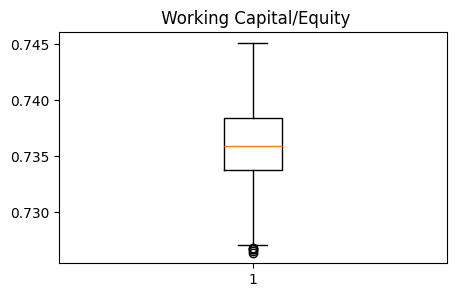

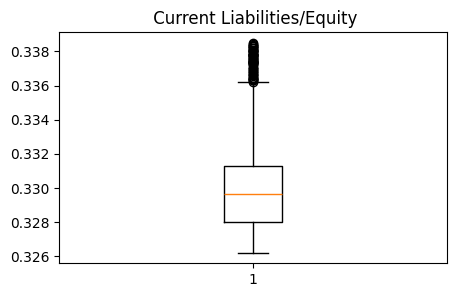

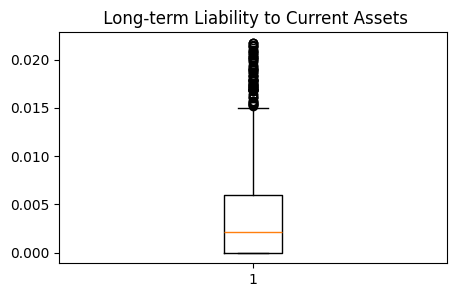

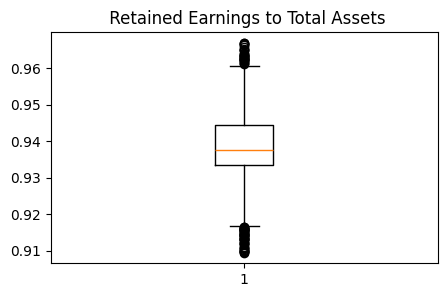

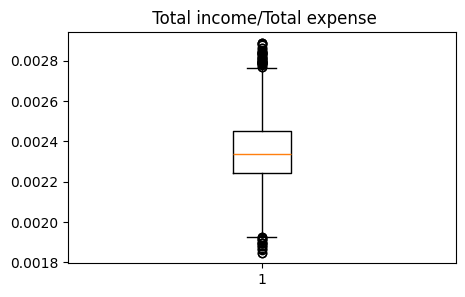

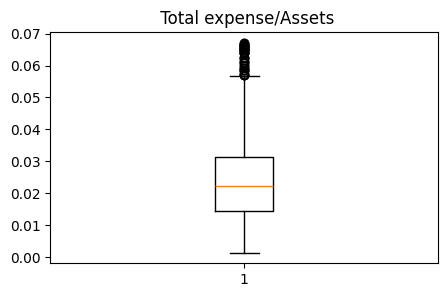

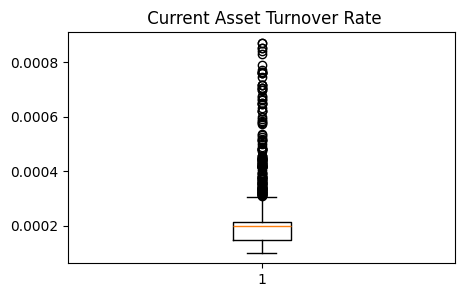

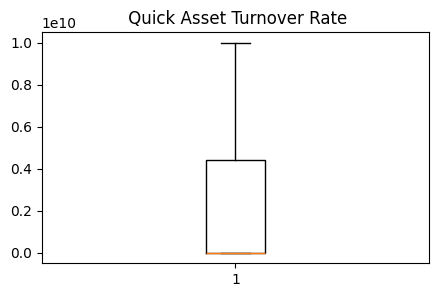

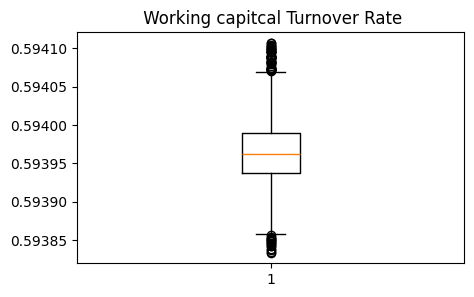

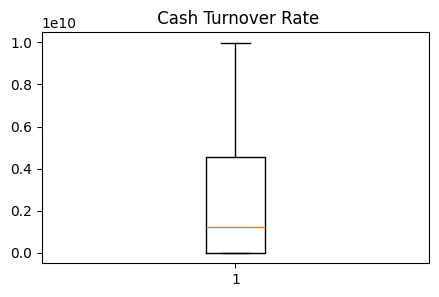

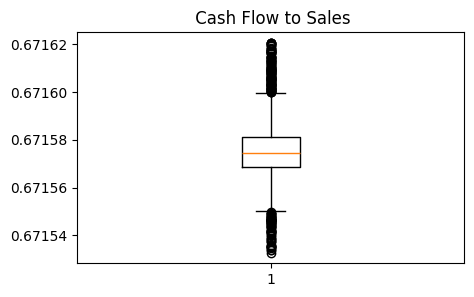

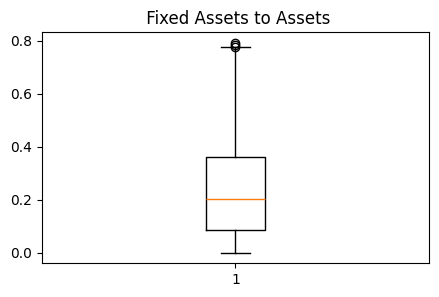

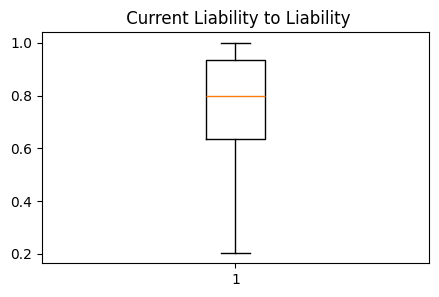

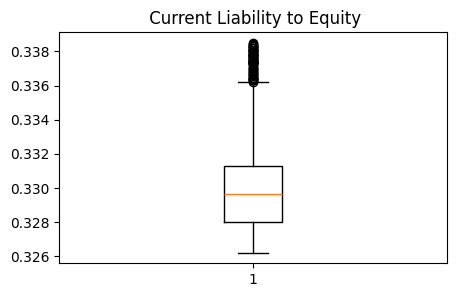

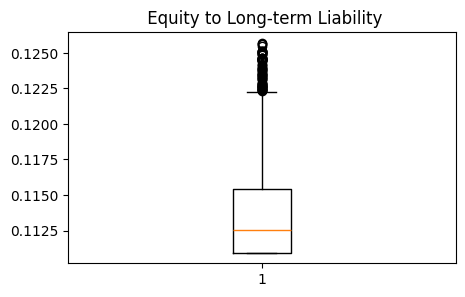

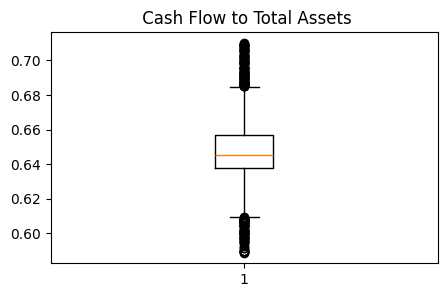

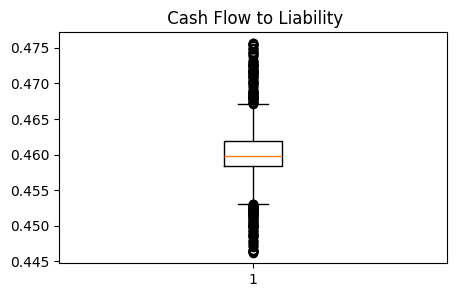

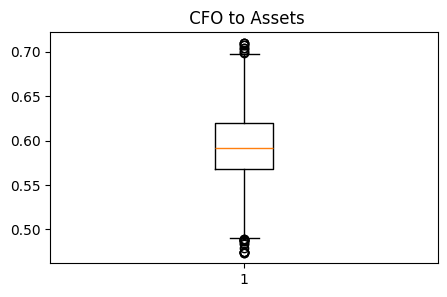

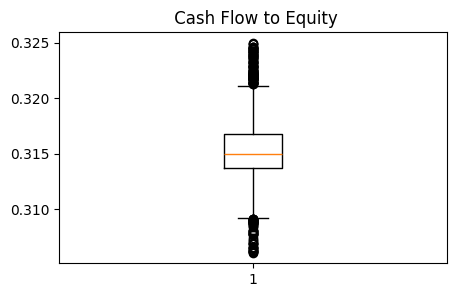

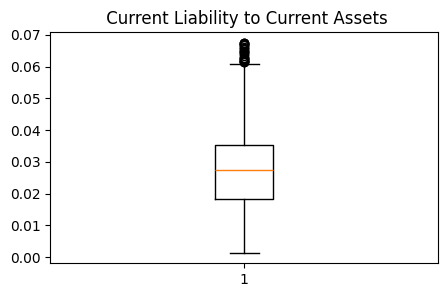

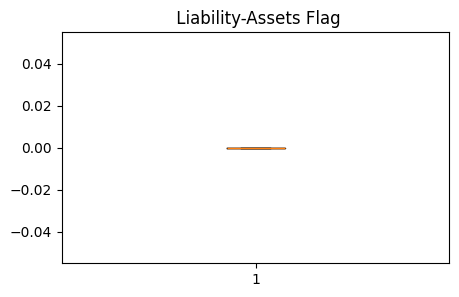

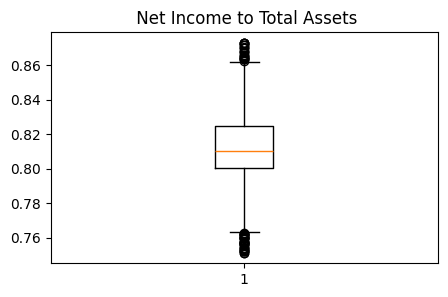

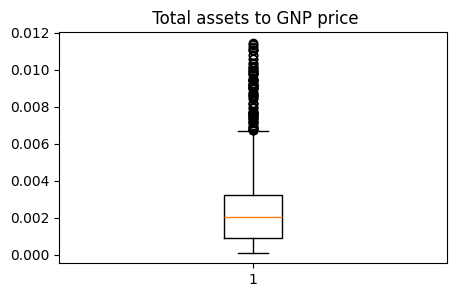

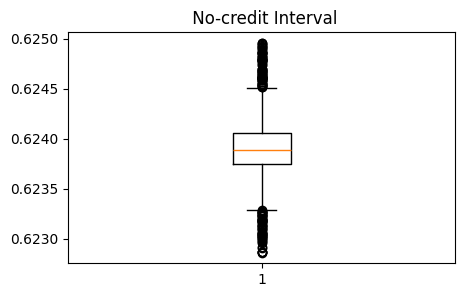

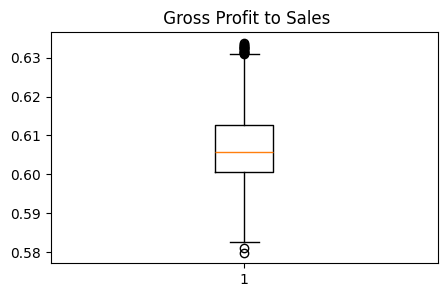

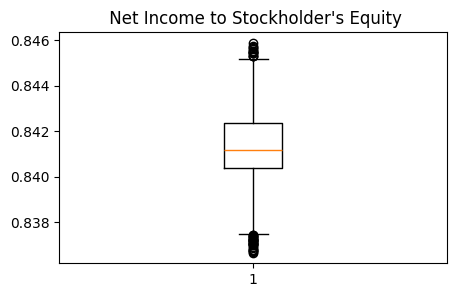

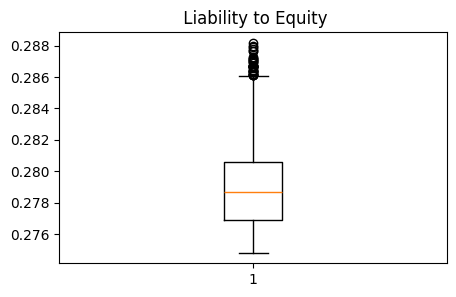

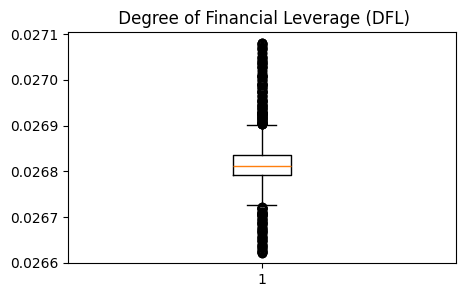

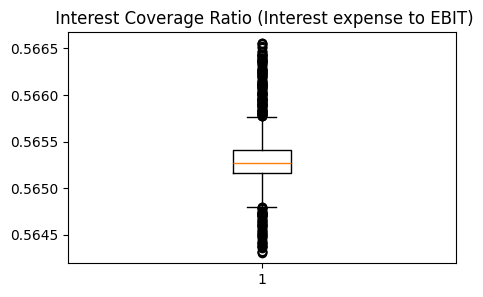

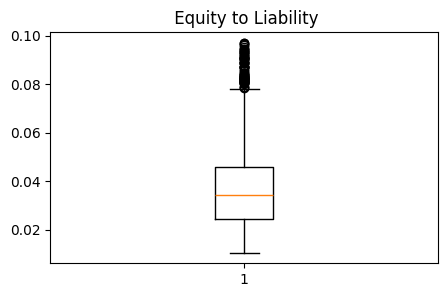

In [152]:
for column in df_x.columns:
    plt.figure(figsize=(5, 3))  # Rozmiar każdego wykresu
    plt.boxplot(df_x[column])  # Rysowanie wykresu pudełkowego dla konkretnej zmiennej
    plt.title(column)  # Tytuł wykresu
    plt.show()

In [153]:
df_x = normalize_data(df_x)
x_train = normalize_data(x_train)

In [154]:
df_x

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.529338,0.549243,0.551387,0.490369,0.487426,0.496408,0.454725,0.460311,0.437598,0.463603,...,0.0,0.524179,0.039827,0.388528,0.490390,0.588650,0.651916,0.902163,0.798498,0.123383
1,0.779286,0.703299,0.847122,0.503210,0.503210,0.781460,0.713411,0.762075,0.545692,0.751118,...,0.0,0.670359,0.879299,0.443690,0.503245,0.649609,0.259364,0.477362,0.478841,0.308172
2,0.481416,0.484743,0.485435,0.479334,0.479066,0.477289,0.478218,0.479000,0.626632,0.995730,...,0.0,0.486472,0.033859,0.587119,0.479332,0.915882,0.100462,0.388230,0.396926,0.759186
3,0.583838,0.592905,0.573759,0.403157,0.401953,0.485284,0.503330,0.508400,0.603655,0.488613,...,0.0,0.594101,0.172833,0.637431,0.403103,0.570178,0.230155,0.573706,0.560834,0.346152
4,0.481416,0.874969,0.485435,0.703986,0.703986,0.477289,0.948515,0.479000,0.491906,0.475397,...,0.0,0.823038,0.172833,0.454017,0.703943,0.919077,0.485992,0.428041,0.434278,0.165742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,0.384005,0.370876,0.384060,0.346709,0.346709,0.254693,0.372817,0.374843,0.744648,0.381456,...,0.0,0.370458,0.047330,0.388323,0.346688,0.368921,0.189727,0.410911,0.426732,0.417123
1428,0.405721,0.452741,0.413890,0.267389,0.268994,0.378679,0.555176,0.558589,0.994256,0.558357,...,0.0,0.501784,0.172833,0.487150,0.267428,0.470813,0.131224,0.380427,0.389454,0.592188
1429,0.639382,0.605309,0.592869,0.706929,0.700642,0.826651,0.616382,0.573499,0.162402,0.587637,...,0.0,0.631951,0.075123,0.591138,0.706899,0.600830,0.219757,0.385008,0.393847,0.362011
1430,0.768428,0.644753,0.724773,0.504682,0.504682,0.682966,0.691629,0.693616,0.704439,0.619561,...,0.0,0.665801,0.172833,0.187357,0.504638,0.588215,0.103456,0.375445,0.384658,0.738929


### From now on, we'll use x_train to train the data and df_x will be used for predictions

### Lasso

ROC AUC score: 0.9188641652853817


C:\Users\sylge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LassoCV was fitted without feature names
  warnings.warn(


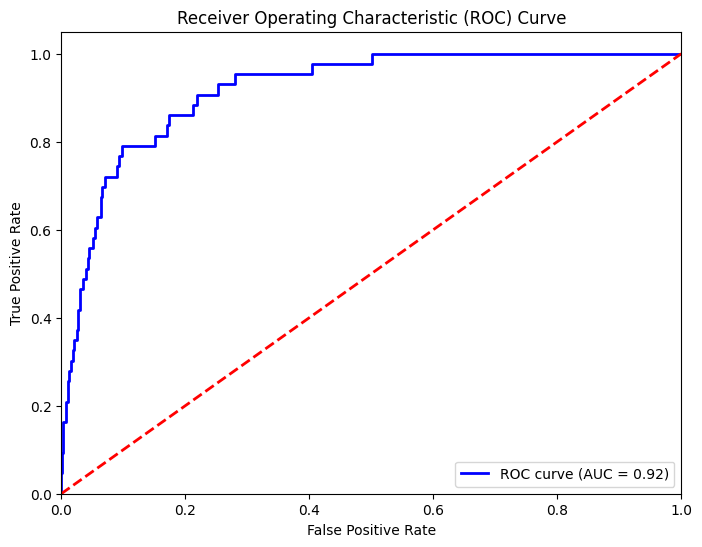

In [155]:
# Standaryzacja danych treningowych
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# Standaryzacja danych testowych
x_test_scaled = scaler.transform(df_x)

# Tworzenie modelu regresji LassoCV z standaryzowanymi danymi
lasso_model = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10], max_iter=1000, cv=5)
lasso_model.fit(x_train_scaled, y_train)

# Wybieramy najlepszą wartość alpha dla naszych danych
pred = lasso_model.predict(df_x)
calculate_metrics(df_y, pred)

### Logistic Regression

In [126]:
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

In [127]:
pred = lr_model.predict(df_x)

In [128]:
df_x

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.529338,0.549243,0.551387,0.490369,0.487426,0.496408,0.454725,0.460311,0.437598,0.463603,...,0.0,0.524179,0.039827,0.388528,0.490390,0.588650,0.651916,0.902163,0.798498,0.123383
1,0.779286,0.703299,0.847122,0.503210,0.503210,0.781460,0.713411,0.762075,0.545692,0.751118,...,0.0,0.670359,0.879299,0.443690,0.503245,0.649609,0.259364,0.477362,0.478841,0.308172
2,0.481416,0.484743,0.485435,0.479334,0.479066,0.477289,0.478218,0.479000,0.626632,0.995730,...,0.0,0.486472,0.033859,0.587119,0.479332,0.915882,0.100462,0.388230,0.396926,0.759186
3,0.583838,0.592905,0.573759,0.403157,0.401953,0.485284,0.503330,0.508400,0.603655,0.488613,...,0.0,0.594101,0.172833,0.637431,0.403103,0.570178,0.230155,0.573706,0.560834,0.346152
4,0.481416,0.874969,0.485435,0.703986,0.703986,0.477289,0.948515,0.479000,0.491906,0.475397,...,0.0,0.823038,0.172833,0.454017,0.703943,0.919077,0.485992,0.428041,0.434278,0.165742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,0.384005,0.370876,0.384060,0.346709,0.346709,0.254693,0.372817,0.374843,0.744648,0.381456,...,0.0,0.370458,0.047330,0.388323,0.346688,0.368921,0.189727,0.410911,0.426732,0.417123
1428,0.405721,0.452741,0.413890,0.267389,0.268994,0.378679,0.555176,0.558589,0.994256,0.558357,...,0.0,0.501784,0.172833,0.487150,0.267428,0.470813,0.131224,0.380427,0.389454,0.592188
1429,0.639382,0.605309,0.592869,0.706929,0.700642,0.826651,0.616382,0.573499,0.162402,0.587637,...,0.0,0.631951,0.075123,0.591138,0.706899,0.600830,0.219757,0.385008,0.393847,0.362011
1430,0.768428,0.644753,0.724773,0.504682,0.504682,0.682966,0.691629,0.693616,0.704439,0.619561,...,0.0,0.665801,0.172833,0.187357,0.504638,0.588215,0.103456,0.375445,0.384658,0.738929


ROC AUC score: 0.5450717430977614


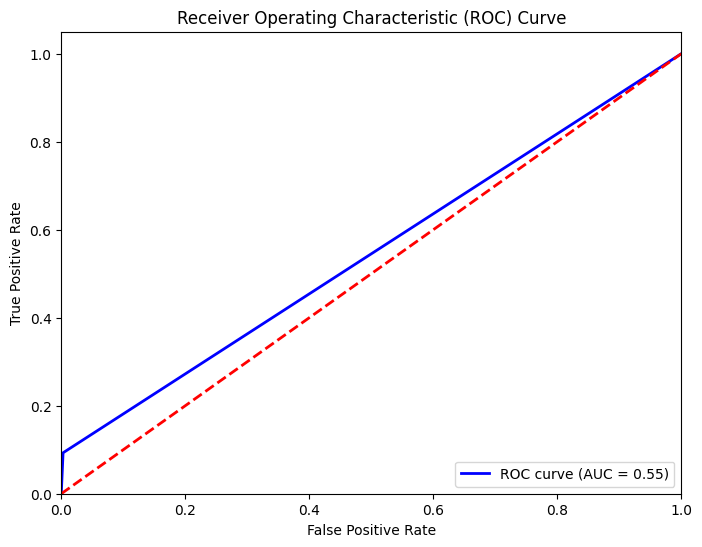

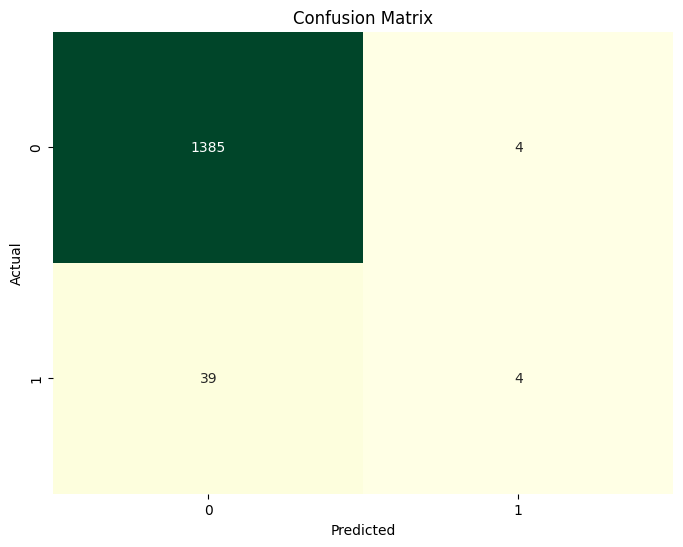

In [129]:
calculate_metrics(df_y, pred)

#zobaczmy co się stanie jak dodamy wagę

In [130]:
lr2_model = LogisticRegression(max_iter=10000, class_weight='balanced')
lr2_model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [131]:
pred = lr2_model.predict(df_x)

ROC AUC score: 0.833902590118372


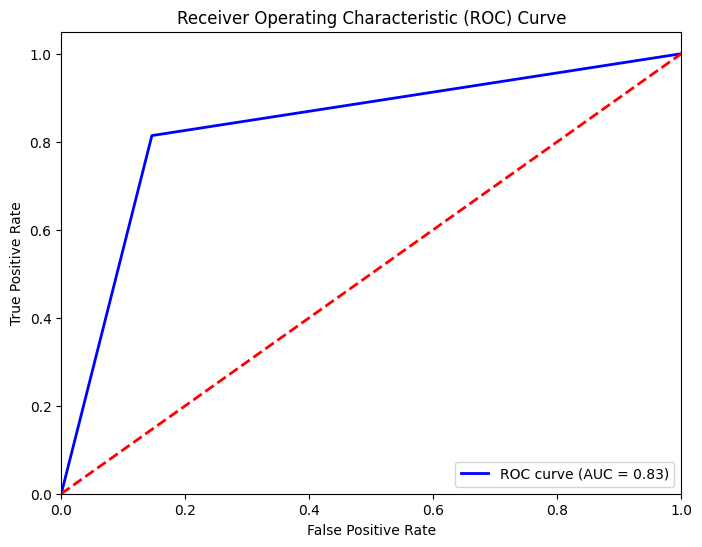

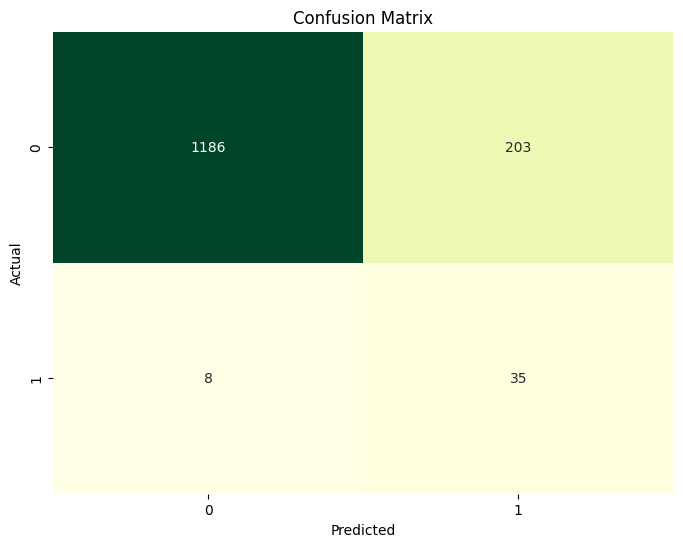

In [132]:
calculate_metrics(df_y, pred)

# DecisionTREE

In [133]:
DT_model = DecisionTreeClassifier() # Create a decision tree classifier object

DT_model.fit(x_train, y_train)

DecisionTreeClassifier()

In [134]:
pred = DT_model.predict(df_x)

ROC AUC score: 0.6459808796691613


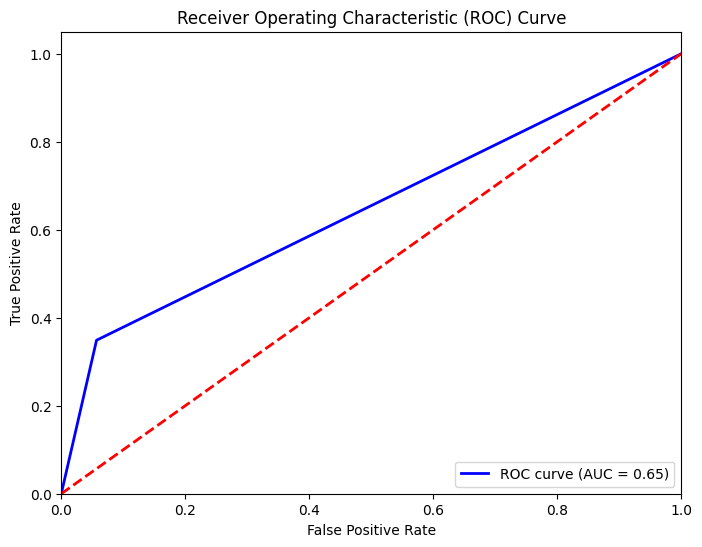

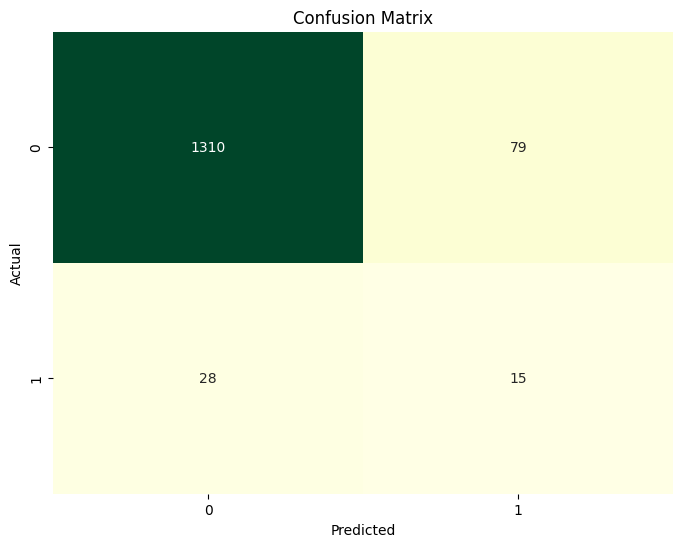

In [135]:
calculate_metrics(df_y, pred)

# Random Forest

In [136]:
RF_model = RandomForestClassifier()

RF_model.fit(x_train, y_train)

predictions = RF_model.predict(df_x)



ROC AUC score: 0.5232558139534884


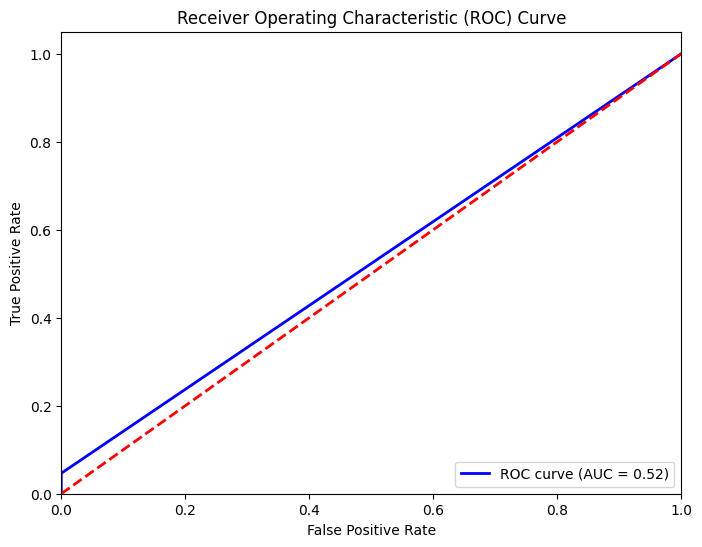

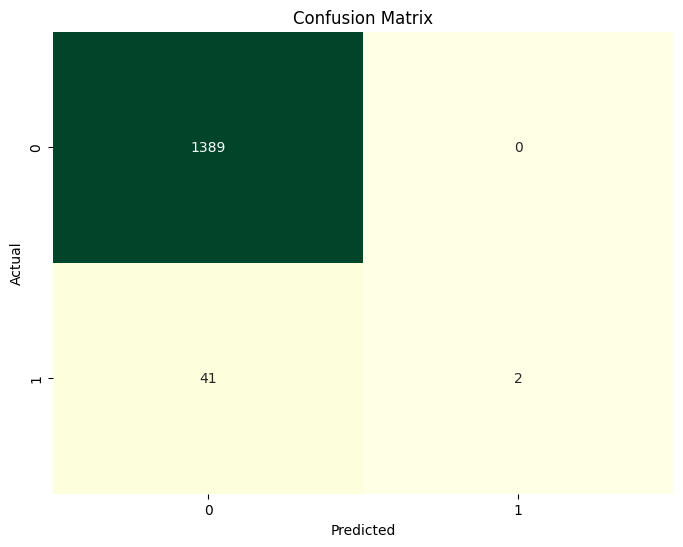

In [137]:
calculate_metrics(df_y, predictions)